---
<div class="alert alert-block alert-info">

## Комментарий от тимлида

Привет!
    <p>К сожалению, у меня упал код на загрузке данных и если к самому датасету я могу переписать путь, то категории мне неизвестны.</p>
    <p>Из того, что я смогла посмотреть: дашборд хороший и максимально информативен, категоризация товаров и сегментация покупателей судя по всему получилась очень интересная. Мне нравится твоя презентация, я не уверена, что стоит ее целиком "показывать заказчику", но как тимлид я получила кучу инсайтов.         </p>
    <p>
 Есть момент, который очень смущает: удалять просто потому что не понравилось cs['avg_check']<2200 - это означает удалить целые товарные категории (лестницы, сумки-тележки, весь хороший инструмент, сушилки и т.д. и т.п.). Есть какое-то бизнес-объяснение этому решению? </p>                                                                 
<p>П.С. Дашборд и презентация приняты. По проекту жду починку загрузки и изменения или объяснения про удаление.</p>
    
</div>

---


Елена, спасибо за комментарий!! Поступила немудро, запрятав ссылку на архив с файлами в презентации :( Исправляюсь! Теперь всё должно заработать  
Прикрепляю ссылку на архив с csv-файликами: https://drive.google.com/file/d/14BsaYHW45B_obGK3txrl-cWXNmRgOHfZ/view?usp=sharing

Попытаюсь объянсить, почему я задала именно такую границу для среднего чека. Во-первых, я ориентировалась на распределение: смотрела на ящик с усами и наблюдения, которые выходят за рамки полутора межквартильных размахов. Кроме этого я пробовала кластеризовать на разных наборах данных (не стала все итерации и попытки в работу включать): если задавать границу для отсечения выбросов выше, алгоритм делает маленький кластер (иногда даже из одного наблюдения) с большим средним чеком, а все остальные наблюдения скидывает в один большой кластер, так как по сравнению с расстоянием до большого среднего чека разница между более типичными средними чеками нивелируется - алгоритм их воспринимает как один большой кластер. То есть не убирая, большие средние чеки я не могу найти отличия между основной массой наблюдения, чего требует задача. Все выбросы по чеку я пометила в работе как группу "нетипичные", по ним тоже можно посмотреть статистику  
Кластеры, которые я получила, статистически значимо отличаются от "типичных" пользователей. Значит мне удалось выявить в основной массе пользователей группы покупателей со своими особенностями и описать их

# Проект: E-commerce — Выявление профилей потребления

## Материалы

Ссылка на дашборд: https://public.tableau.com/profile/ekaterina3818#!/vizhome/FinalProjectE-comm/Dashboard1

Ссылка на презентацию: https://docs.google.com/presentation/d/1NT2u6Ozs42NA4NLYdEbfCI1RtS4-mT2QCNXP3ExrBT0/edit#slide=id.p

Ссылка на архив с csv-файлами: https://drive.google.com/file/d/14BsaYHW45B_obGK3txrl-cWXNmRgOHfZ/view?usp=sharing

**Задача**: предложить сегментацию потребителей, чтобы сформулировать персонализированное предложение. Заказчик ожидает готовые идеи/алгоритмы на основании полученных профилей. Желательно делать упор на визуацлизацию 

**Данные**  
Датасет с транзакциями интернет-магазина товаров для дома и быта «Пока все ещё тут»
- `date` — дата заказа (с точностью до часа)
- `customer_id` — идентификатор покупателя
- `order_id` — идентификатор заказа
- `product` — наименование товара
- `quantity` — количество товара в заказе
- `price` — цена товара

**Содержание:**  
1. <a href='#import'>Импорт и предобработка данных</a>
2. <a href='#eda'>Разведывательный анализ</a>
3. <a href='#cluster'>Кластеризация</a>
4. <a href='#test'>Тестирование статистических гипотез</a>
5. <a href='#concl'>Выводы и предложения</a>

<a id='import'></a>

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy
from scipy import stats as st
from scipy.stats import norm 
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('C:\\Users\\akimo\\ecommerce_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В датафрейме 6737 наблюдений. Пропущенных значений в данных нет. Дату необходимо преобразовать в корретный формат

In [4]:
display(df.head(5))

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Преобразуем дату в корректный формат - дата и часы. Вычисляю первый день месяца для удобства анализа

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [6]:
df['firstdayofmonth'] = df['date'].values.astype('datetime64[M]')

*Проверка на дубликаты*

In [7]:
df.duplicated().sum()

0

Полностью повторяющихся строк нет

In [8]:
df.groupby(['order_id'])['date'].nunique().sort_values(ascending=False)

order_id
14833    74
70960    60
69162    23
71148    16
69531    12
         ..
71225     1
71223     1
71222     1
71220     1
12624     1
Name: date, Length: 2784, dtype: int64

In [9]:
df[df['order_id']==13547]

,date,customer_id,order_id,product,quantity,price,firstdayofmonth
102,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10-01
103,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10-01
104,2018-10-05 00:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10-01
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10-01
377,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10-01
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10-01
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-10-01
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-10-01
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-10-01
588,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11-01


Но есть строки, у которых внутри одного идентификатора заказа встречаются разные даты. Скорее всего, такая ситуация возникла из-за того, что в датафрейме сохранились записи из промежуточных статусов заказа (оформление заказа - статус оплаты - отправлено на доставку и т.д.) Чтобы избавиться от дублей я возьму записи из максимальной даты внутри одного заказа, так как к этой дате заказ точно будет оплачен, и это можно будет считать полноценной покупкой

In [10]:
final_order = df.groupby(['order_id'])['date'].max().reset_index()

In [11]:
df = df.merge(final_order, on=['order_id', 'date'], how='inner')

In [12]:
df[df['order_id']==13547]

,date,customer_id,order_id,product,quantity,price,firstdayofmonth
693,2018-11-16 16:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по ...,1,315.0,2018-11-01
694,2018-11-16 16:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете п...,1,207.0,2018-11-01
695,2018-11-16 16:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0,2018-11-01


In [13]:
df.groupby(['order_id'])['customer_id'].nunique().sort_values(ascending=False)

order_id
71571    2
69515    1
69527    1
69525    1
69524    1
        ..
71333    1
71331    1
71330    1
71329    1
12624    1
Name: customer_id, Length: 2784, dtype: int64

После удаления дублей внутри заказа остались две дублирующие записи, у которых внутри одного заказа два разных id покупателя. Нужно удалить одну запись, чтобы не задваивалась сумма заказа

In [14]:
df = df[(df['customer_id'] != 'f1222eaa-d09d-4bff-ab4e-bea6fe3f68a8')]

Считаю стоимость 

In [15]:
df['cost'] = df['quantity'] * df['price']

*Присвоение товарных категорий*

Я пробовала присовить категории с сайта https://www.1d.ru, на котором я нашла похожие категории. Но не все товары нашлись на сайте (наверное, часть товаров в датайфрейме устарела), поэтому я проставила оставшиеся категории вручную и сохранила в csv под названием category.  
Кусочки кода с парсингом я закомментировала, итоговый файл подгружен ниже

In [16]:
#url = 'https://www.1d.ru/catalog/komnatnye_rasteniya/'
#content=[] 
#num_of_page = 48

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
        
#cat = pd.DataFrame(content, columns=['product']) 
#cat['category'] = 'Комнантные растения'

In [17]:
#url = 'https://www.1d.ru/catalog/rassada_i_sazhentsy/'
#content=[] 
#num_of_page = 169

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
#cat2 = pd.DataFrame(content, columns=['product']) 
#cat2['category'] = 'Рассада и саженцы'

In [18]:
#url = 'https://www.1d.ru/catalog/tovary_dlya_doma/'
#content=[] 
#num_of_page = 283

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
#cat3 = pd.DataFrame(content, columns=['product']) 
#cat3['category'] = 'Товары для дома'

In [19]:
#url = 'https://www.1d.ru/catalog/tovary_dlya_dachi/'
#content=[] 
#num_of_page = 303

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
#cat4 = pd.DataFrame(content, columns=['product']) 
#cat4['category'] = 'Товары для дачи'

In [20]:
#url = 'https://www.1d.ru/catalog/mebel/'
#content=[] 
#num_of_page = 70

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
#cat5 = pd.DataFrame(content, columns=['product']) 
#cat5['category'] = 'Мебель для дома и дачи'

In [21]:
#url = 'https://www.1d.ru/catalog/tovary_dlya_bani_i_sauny/'
#content=[] 
#num_of_page = 63

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
#cat6 = pd.DataFrame(content, columns=['product']) 
#cat6['category'] = 'Товары для бани и сауны'

In [22]:
#url = 'https://www.1d.ru/catalog/tekstil/'
#content=[] 
#num_of_page = 184

#for i in range(1, num_of_page+1): 
#    r = requests.get(url, {'PAGEN_1': str(i)})  
#    soup = BeautifulSoup(r.text, 'lxml')
#    quotes = soup.find_all('div', class_='item-title')
#    for quote in quotes:
#        content.append(quote.text)
#cat7 = pd.DataFrame(content, columns=['product']) 
#cat7['category'] = 'Текстиль'

In [23]:
#category = pd.concat([cat, cat2, cat3, cat4, cat5, cat6, cat7])
#category = (category.replace('\n', '', regex=True))

In [24]:
category = pd.read_csv('C:\\Users\\akimo\\category_2.csv')

In [25]:
category = category[['product', 'category']]

In [26]:
df = df.merge(category, on = 'product', how='left')

<a id='eda'></a>

**EDA**

In [27]:
df.describe()

,order_id,quantity,price,cost
count,4792.000000,4792.000000,4792.000000,4792.000000
mean,48168.362688,2.824499,515.723915,853.285893
std,27354.950838,17.720407,947.658012,9889.271285
min,12624.000000,1.000000,9.000000,9.000000
25%,14770.000000,1.000000,90.000000,120.000000
50%,68858.000000,1.000000,150.000000,192.500000
75%,70832.250000,1.000000,488.000000,734.000000
max,73164.000000,1000.000000,14917.000000,675000.000000


In [28]:
 df.groupby('category').agg({'order_id' : 'nunique', 'price' : 'median', 'quantity': 'median'})

,order_id,price,quantity
category,,,
Бытовая химия,18,134.0,1
Комнатные растения,573,149.0,1
Мебель для дома и дачи,52,1386.5,1
Посуда,182,183.0,1
Рассада и саженцы,273,90.0,1
Текстиль,149,937.0,1
Техника,19,985.5,1
Товары для дачи,3,38.0,40
Товары для дома,1659,488.0,1


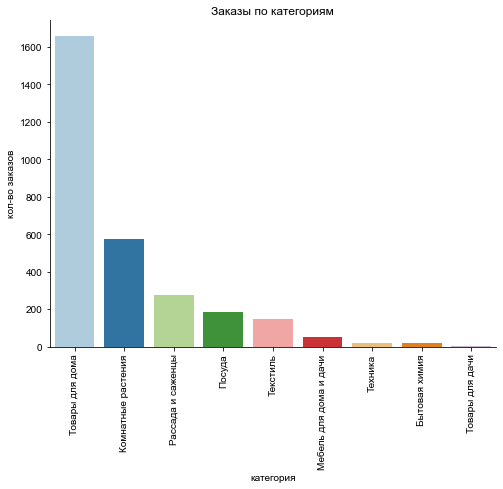

In [29]:
category_n = df.groupby('category')['order_id'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='category', y='order_id', 
              data=category_n, palette="Paired")
sns.set_style("ticks") 
sns.despine()
plt.xlabel('категория')
plt.ylabel('кол-во заказов')
plt.xticks(rotation=90)
plt.title('Заказы по категориям'); 

Больше всего заказов в категории Товары для дома. На втором месте Комнатные растения, на третьем - Рассада и саженцы. Самые "дорогие товарные категории" (с самой большой медианной ценой) - мебель и техника. В категории товары для дачи медиана для количества товаров 40 - это сильно превышает показатель в остальных категориях. Скорее всего, это статистический выброс. Выбросы я подробнее проанализмрую перед тем как делать кластеризацию

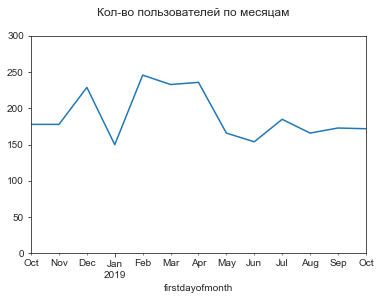

In [30]:
df.groupby('firstdayofmonth')['customer_id'].nunique().plot()
plt.ylim(0, 300)
plt.suptitle("Кол-во пользователей по месяцам");

Больше всего пользователей совершают покупки в феврале, марте и апреле. Меньше всего - в январе и июне

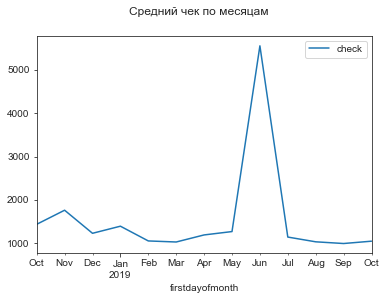

In [31]:
av_ch = df.groupby('firstdayofmonth').agg({'order_id' : 'nunique', 'cost': 'sum'}).reset_index()
av_ch['check'] = av_ch['cost'] / av_ch['order_id']
av_ch.plot(x='firstdayofmonth', y='check')
plt.suptitle("Средний чек по месяцам");

В июне виден всплеск по величине среднего чека (тоже скорее всего выброс, который может помешать на этапе статистического анализа). Средний чек выше в ноябре и январе по сравнению с другими месяцами. Значит в январе было мало заказов, но на чуть бОльшую сумму

<a id='cluster'></a>

**Кластеризация**

Для кластеризации я буду использовать метрики:
- `n_orders` - количество заказов
- `avg_check`  - средний чек
- `n_months` - количество месяцев с заказами
- `n_categories` - количество категорий в заказе
- `avg_quantity` - среднее количество товаров в заказе

Средний чек и количество заказов - основные очевидные метрики "успешности" нашего магазина и поведения клиентов

Среднее количество товаров в заказе - позволит определить пользователей, которые пришли за разнообразными товарами, а не за какой-то конкретной вещью

Количество категорий в заказе - позводит учесть товарные категории. Чем больше товарных категорий в заказе, тем более разнообразные товары заказал пользовтель

Количество месяцев взято для того, чтобы учесть пользователей, которые совершают заказы не разово, а на протяжении нескольких месяцев

In [32]:
cs = df.groupby('customer_id').agg({'order_id' : 'nunique',
                                           'quantity': 'sum', 'firstdayofmonth':'nunique', 
                                           'category': 'nunique', 'cost': 'sum'}).reset_index()

In [33]:
cs.columns = ['customer_id', 'n_orders', 'quantity',  'n_months', 'n_categories', 'cost']

In [34]:
cs['avg_check'] = cs['cost'] / cs['n_orders']
cs['avg_quantity'] = cs['quantity'] / cs['n_orders']

In [35]:
cs = cs[['customer_id','n_orders', 'avg_check',  'n_months', 'n_categories', 'avg_quantity']]

Прежде чем приступить к кластеризации, смотрю на распределение атрибутов

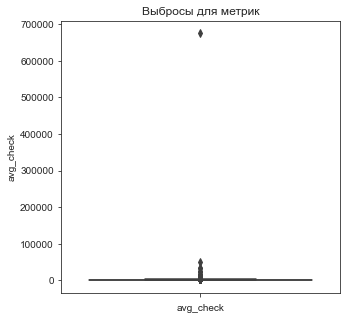

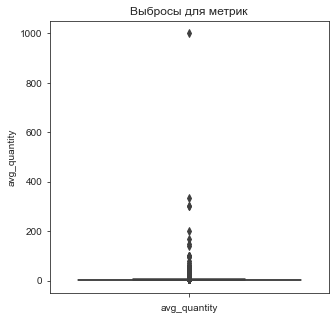

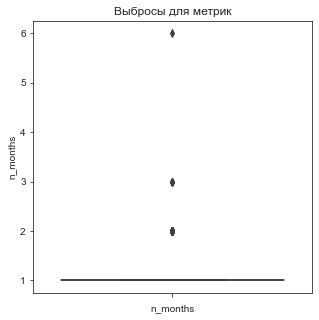

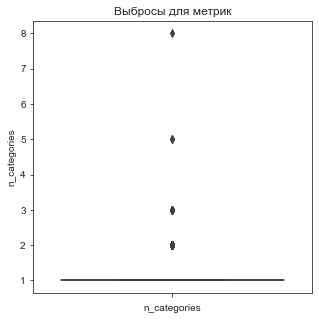

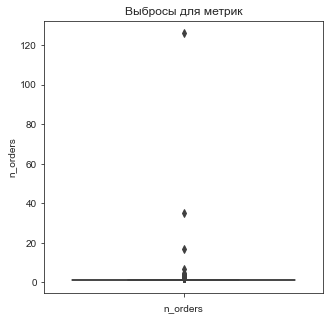

In [36]:
plt.figure(figsize=(5, 5))
sns.boxplot(data = cs, y='avg_check').set_title('Выбросы для метрик')
sns.color_palette("Set2")
plt.xlabel('avg_check');

plt.figure(figsize=(5, 5))
sns.boxplot(data = cs, y='avg_quantity').set_title('Выбросы для метрик')
sns.color_palette("Set2")
plt.xlabel('avg_quantity');

plt.figure(figsize=(5, 5))
sns.boxplot(data = cs, y='n_months').set_title('Выбросы для метрик')
sns.color_palette("Set2")
plt.xlabel('n_months');

plt.figure(figsize=(5, 5))
sns.boxplot(data = cs, y='n_categories').set_title('Выбросы для метрик')
plt.xlabel('n_categories');

plt.figure(figsize=(5, 5))
sns.boxplot(data = cs, y='n_orders').set_title('Выбросы для метрик')
sns.color_palette("Set2")
plt.xlabel('n_orders');

In [37]:
cs.describe()

,n_orders,avg_check,n_months,n_categories,avg_quantity
count,2421.000000,2421.000000,2421.000000,2421.000000,2421.000000
mean,1.149938,1497.389008,1.018587,1.066501,4.962692
std,2.671442,13857.194591,0.172684,0.311152,25.330141
min,1.000000,15.000000,1.000000,1.000000,1.000000
25%,1.000000,294.500000,1.000000,1.000000,1.000000
50%,1.000000,674.000000,1.000000,1.000000,1.000000
75%,1.000000,1447.000000,1.000000,1.000000,3.000000
max,126.000000,675000.000000,6.000000,8.000000,1000.000000


In [38]:
df[df['customer_id']=='312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6']

,date,customer_id,order_id,product,quantity,price,firstdayofmonth,cost,category
3770,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06-01,675000.0,Товары для дома


На ящике с усами видно, что у метрик есть статистические выбросы, превышающие полтора межквартильных размаха. Эти выбросы могут повлиять на результаты кластеризации. Из-за нескольких выбросов каждый выброс будет попадать в отдельный кластер, а все остальные наблюдения по сравнению с ними будут попадать в один большой кластер, и мы не сможем отличать их друг от друга. Например, мы видим пользователя '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6', который заказал 1000 вантузов с деревянной ручкой - это очеивдно нетипичный случай.  
По этой причине для кластеризации я откину сильно выбивающиеся значения (пороги я установила на своё усмотрение исходя из графиков и медиан)

In [39]:
cs = cs[cs['avg_check']<2200]
cs = cs[cs['n_orders']<=20]
cs = cs[cs['avg_quantity']<=10]

In [40]:
X = cs.drop(columns=['customer_id'])

Чтобы разделить наблюдения на кластеры, провожу стандартизацию

In [41]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [42]:
linked = linkage(X_sc, method = 'ward')

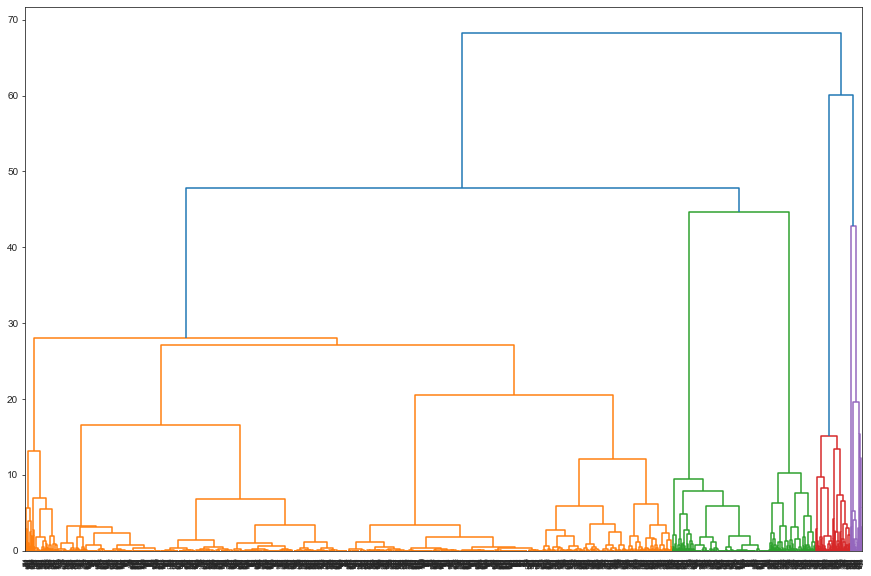

In [43]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

In [44]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

In [45]:
cs['cluster_km'] = labels

Так как при каждом прогоне порядок кластеров меняется (а порядок важен для дальнейших стат тестов), я сохранила одну версию в формате csv и дальше буду работать с ней

In [46]:
#cs.to_csv("ecomm_data_clusters.csv", sep='\t')

In [47]:
cs = pd.read_csv('C:\\Users\\akimo\\ecomm_data_clusters.csv', sep='\t')
cs = cs[['customer_id','n_orders', 'avg_check',  'n_months', 'n_categories', 'avg_quantity', 'cluster_km']]

In [48]:
cs.groupby('cluster_km')['customer_id'].nunique()

cluster_km
0     175
1    1198
2      80
3      28
4     473
Name: customer_id, dtype: int64

In [49]:
cs.groupby('cluster_km').mean()

,n_orders,avg_check,n_months,n_categories,avg_quantity
cluster_km,,,,,
0,1.108571,727.594286,1.000000,1.000000,7.153333
1,1.045910,357.593907,1.000000,1.000000,1.360740
2,1.200000,858.129167,1.000000,2.062500,5.100000
3,3.035714,626.112020,2.071429,1.392857,2.995748
4,1.044397,1365.177590,1.000000,1.000000,1.217759


Кластеры получились неравноверными по количеству наблюдений. Описательные статистики позволяют содержательно разделить пользователей на группы  
Кластер 0 - кластер с пользователями, у которых в среднем больше всего товаров в заказе  
Кластер 1 - кластер с типичными пользователями. Здесь в среднем самый маленький средний чек  
Кластер 2 - кластер с пользователями, у которых в среднем заказно больше категорий, чем в других группах  
Кластер 3 - кластер с большим числом заказов  
Кластер 4 - кластер с самым большим средним чеком  

In [50]:
cluster = cs[['customer_id', 'cluster_km']]
df = df.merge(cluster, on='customer_id', how='left')

In [51]:
def groups(df):
    if df['cluster_km'] == 1:
        return 'типичный'
    if df['cluster_km'] == 3:
        return 'больше заказов'
    if df['cluster_km'] == 4:
        return 'большой средний чек'
    if df['cluster_km'] == 2:
        return 'больше категорий'
    if df['cluster_km'] == 0:
        return 'больше среднее количество в заказе'
    else:
        return 'нетипичный'


df['cluster'] = df.apply(groups, axis=1)

In [52]:
pd.pivot_table(data=df, values="order_id",columns="cluster",index="category"
               , aggfunc='nunique').reset_index().sort_values(by='типичный')

cluster,category,больше заказов,больше категорий,больше среднее количество в заказе,большой средний чек,нетипичный,типичный
7,Товары для дачи,NaN,NaN,NaN,NaN,2.0,1.0
6,Техника,2.0,1.0,NaN,5.0,5.0,6.0
0,Бытовая химия,NaN,3.0,3.0,NaN,2.0,10.0
2,Мебель для дома и дачи,2.0,2.0,1.0,17.0,16.0,14.0
5,Текстиль,NaN,7.0,7.0,61.0,37.0,37.0
4,Рассада и саженцы,16.0,56.0,45.0,8.0,89.0,59.0
3,Посуда,NaN,12.0,22.0,28.0,34.0,86.0
1,Комнатные растения,45.0,68.0,34.0,17.0,73.0,336.0
8,Товары для дома,28.0,26.0,82.0,358.0,461.0,704.0


Пользователи с большим числом заказов и категорий делают больше заказов в категории рассада и саженцы и комнатные растения
Пользователи с большим средним чеком больше больше заказывает текстиль, чем остальные

In [66]:
df[df['cluster'] == "нетипичный"].describe()

,order_id,quantity,price,cost,cluster_km
count,1801.000000,1801.000000,1801.000000,1801.000000,0.0
mean,38956.683509,5.060522,692.259300,1494.399778,NaN
std,27406.983924,28.705191,1398.595976,16100.771589,NaN
min,14514.000000,1.000000,9.000000,9.000000,NaN
25%,14705.000000,1.000000,59.000000,90.000000,NaN
50%,14845.000000,1.000000,120.000000,169.000000,NaN
75%,69090.000000,2.000000,299.000000,1060.000000,NaN
max,73110.000000,1000.000000,14917.000000,675000.000000,NaN


In [ ]:
Для "нетипичного" кластера, куда я отнесла все статистические выбросы для среднего чека, характерны 

<a id='test'></a>

**Тестирование статистических гипотез**

Я хочу протестировать две статистические гипотезы:
1. В кластере два средний чек статистически значимо больше, чем в кластере ноль
2. В кластере четыре среднее кол-во товаров в заказе больше, чем в кластере ноль

Таким образом я хочу сравнить два самых ярких кластера с типичным кластером. Кроме того в этих группах достаточно наблюдений для статистического теста

**Гипотеза о равенстве средних чеков в кластерах 1 и 4**

*Нулевая гипотеза:* нет статистически значимых различий для среднего чека в двух группах

*Альтернативная гипотеза:* статистически значимые различия для среднего чека есть. Средний чек в группе 4 больше, чем в группе 1 (Это мы увидели на этапе разведывательного анализа после кластеризации)

Принимаю уровень значимости 0,05, так как объём выборки не очень велик 

Предполагаю, что выборки независимы: каждый пользователь входит только в один кластер. Поэтому для проверки гипотезы выбран тест Стьюдента для независимых выборок.

Так как альтернативная гипотеза односторонняя, полученное p-value нужно разделить на 2

Получаю очень маленькое значение p-value. Следовательно, я отвергаю нулевую гипотезу о том, что средний чек для двух групп не отличается друг от друга. Делаю выбор в пользу альтернативы: средний чек для кластера 4 больше

In [53]:
check1 = cs[cs['cluster_km'] == 1]['avg_check']
check4 = cs[cs['cluster_km'] == 4]['avg_check']

In [55]:
check1.mean()

357.5939065108514

In [56]:
check4.mean()

1365.1775898520084

In [57]:
alpha = .05

results = st.ttest_ind(check1, check4)

print('p-значение:', results.pvalue/2)

if (results.pvalue/2 < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


**Гипотеза о равенстве среднего количества товаров в заказе в кластерах один и ноль**

*Нулевая гипотеза:* нет статистически значимых различий для среднего количества товаров в заказе в двух группах

*Альтернативная гипотеза:* статистически значимые различия для среднего количества товаров в заказе есть. Среднее количество товаров в группе ноль больше, чем в группе один (Это мы увидели на этапе разведывательного анализа после кластеризации)

Принимаю уровень значимости 0,05, так как объём выборки не очень велик 

Предполагаю, что выборки независимы: каждый пользователь входит только в один кластер. Поэтому для проверки гипотезы выбран тест Стьюдента для независимых выборок.

Так как альтернативная гипотеза односторонняя, полученное p-value нужно разделить на 2

Получаю очень маленькое значение p-value. Следовательно, я отвергаю нулевую гипотезу о том, что среднее количество товаров в заказе для двух групп не отличается друг от друга. Делаю выбор в пользу альтернативы: среднее количество товаров в заказе для нулевого кластера больше

In [58]:
quantity1 = cs[cs['cluster_km'] == 1]['avg_quantity']
quantity0 = cs[cs['cluster_km'] == 0]['avg_quantity']

In [59]:
quantity0.mean()

7.153333333333334

In [60]:
quantity1.mean()

1.3607401224262659

In [61]:
alpha = .05

results = st.ttest_ind(quantity1, quantity0)

print('p-значение:', results.pvalue/2)

if (results.pvalue/2 < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


<a id='concl'></a>

**Выводы и предложения**

1. Число заказов ненамного превышает число пользователей, следовательно чаще всего покупатель делает заказ 1 раз. Нужно подумать о том, как привлекать людей повторно
2. Больше всего заказов сделано в категории товары для дома. В эту категорию входит больше всего товаров. Возможно стоит пересмотреть разделение на товарные категории на сайте, чтобы они были более удобными и для пользователей, и для дальнейшего анализа
3. Меньше всего заказов сделано в январе. Больше всего - в феврале, марте и апреле. Скорее всего январь не лучший месяц для акций и персонализированных предложений. Покупатели пассивны и средства на маркетинг будут потрачены зря. Активизироваться стоит ближе к весне
4. Кластеризация позволила выделить пять сегментов пользователей (после того как мы откинули не типичные наблюдения). Пользователи разных кластеров статистически значимо отличаются от типичных по среднему чеку и количеству товаров
5. Для пользователей из кластера с большим числом заказов и категорий можно делать специализированные предложения на растения и сопутствующие растениям товары, делать рассылку с информацией на почту, делать акции весной, когда сезон для саженцев. Для пользователей с большим средним чеком можно чаще показывать в выдаче товары из категории текстиль и товары для дома (растения таких пользователей судя по количеству заказов интересуют несильно)
